In [1]:
import pandas as pd
import glob, os, re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import scipy.io as spio
from scipy import signal
from collections import defaultdict
from datetime import datetime, timedelta
from obspy import read, Trace, UTCDateTime
from scipy.io.wavfile import read as wavread
def to_pandas(data_set):
    datadict = {}
    for strg in data_set['detec']._fieldnames:
        elem = data_set['detec'].__dict__[strg]
        if isinstance(elem, spio.matlab.mat_struct):
            datadict[strg] = _todict(elem)
        else:
            datadict[strg] = elem
    if isinstance(elem, np.ndarray):
        return pd.DataFrame(datadict)
    else:
        return pd.DataFrame(datadict, index=[0])
def getinfo(place, year, index):
    df = pd.read_csv('../DataBase/Experiment_period.txt')
    df_ = df[df['region']==place][df['year']==year][df['index']==index]
    S = -1*df_['h_calib'].values[0]
    begintime = pd.to_datetime(df_['begin'].values[0])
    endtime = pd.to_datetime(df_['end'].values[-1])
    # month = str(begintime.month).zfill(2)
    return begintime, endtime, S

def calib(data, S):
    return data / ((10)**(S/20))
def readwav(path, S):
    rate, data = wavread(path)
    data = data.astype(np.float32, order='C') / 32768.0
    data = calib(data, S)
    
    tr = Trace()
    tr.data = data
    tr.stats.sampling_rate = rate
    date = path.rsplit('.')[1]
    tr.stats.starttime = UTCDateTime(f'20{date[:12]}')
    tr.decimate(5, no_filter=True)
    # print(trslice.stats.statttime)
    tr = tr.filter('bandpass', freqmin=500, freqmax=6000, corners=4, zerophase=True)
    return tr

def ccf_coeff(tr1, tr2):
    tr1_spec = np.fft.rfft(tr1.data)
    tr2_spec = np.fft.rfft(tr2.data)
    tr1_spec = signal.savgol_filter( abs(tr1_spec)/max(abs(tr1_spec)) , 20, 1, mode='nearest')
    tr2_spec = signal.savgol_filter( abs(tr2_spec)/max(abs(tr2_spec)) , 20, 1, mode='nearest')

    freq = np.linspace(0, tr1.stats.sampling_rate, tr1.stats.npts // 2 + 1)
    fidx = np.where((freq>=500)&(freq<=6000))[0]
    fminidx = fidx[0]; fmaxidx = fidx[-1]
    coeff = np.corrcoef(tr1_spec[fminidx:fmaxidx], tr2_spec[fminidx:fmaxidx])
    
    # plt.figure(figsize=(6,4))
    # plt.subplot(211)
    # plt.plot(tr1.times(), tr1.data/max(tr1.data), 'k')
    # plt.plot(tr2.times(), tr2.data/max(tr2.data), 'r', alpha=0.5)
    # plt.xlim(tr2.times()[0], tr2.times()[-2])
    # plt.xlabel('Time (s)')
    # plt.subplot(212)
    # plt.plot(freq[fminidx:fmaxidx], tr1_spec[fminidx:fmaxidx], 'k')
    # plt.plot(freq[fminidx:fmaxidx], tr2_spec[fminidx:fmaxidx], 'r', alpha=0.5)
    # plt.xlim(500, 6000)
    # plt.xlabel('Frequency (Hz)')
    # plt.suptitle(f'coeff: {round(coeff[0][1],2)}')
    return coeff

In [2]:
path = '/Volumes/home/Research/Detect_fish/Taoyuan_csv'
wavdir = '/Volumes/Data/Soundscape/03_TaoYuan/2023/20230818-20230902/wav'
begin, end, S = getinfo('Taoyuan', 2023, 3)
examplepath  = '/Users/tong/Documents/09_IONTU/Results/sound/Taoyuan_fish_chorus_0619194340_downsampling.wav'
tr_ex = read(examplepath)[0]

/var/folders/07/_m900g1931d1pc5dgv3v4qpw0000gn/T/ipykernel_36638/2804101023.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_ = df[df['region']==place][df['year']==year][df['index']==index]


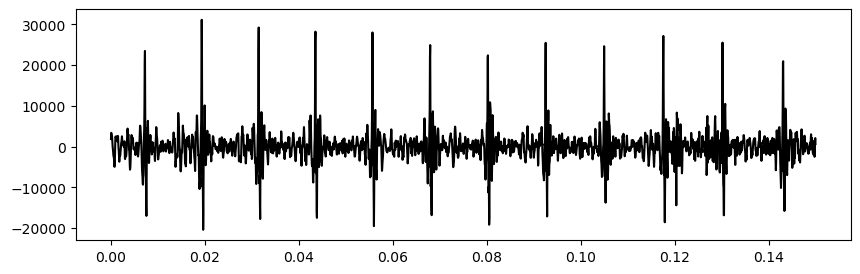

In [3]:
plt.figure(figsize=(10,3))
tr_ex_slice = tr_ex.slice(starttime = tr_ex.stats.starttime+1.325, endtime = tr_ex.stats.starttime+1.475)
tr_ex_slice = tr_ex_slice.filter('bandpass', freqmin=500, freqmax=6000, corners=4, zerophase=True)
plt.plot(tr_ex_slice.times(), tr_ex_slice.data, 'k')

/Volumes/home/Research/Detect_fish/Taoyuan_csv/23081811 264
/Volumes/home/Research/Detect_fish/Taoyuan_csv/23081812 13
/Volumes/home/Research/Detect_fish/Taoyuan_csv/23081813 22
/Volumes/home/Research/Detect_fish/Taoyuan_csv/23081814 8
/Volumes/home/Research/Detect_fish/Taoyuan_csv/23081815 21
/Volumes/home/Research/Detect_fish/Taoyuan_csv/23081816 1
/Volumes/home/Research/Detect_fish/Taoyuan_csv/23081817 6
/Volumes/home/Research/Detect_fish/Taoyuan_csv/23081818 12
/Volumes/home/Research/Detect_fish/Taoyuan_csv/23081819 6
/Volumes/home/Research/Detect_fish/Taoyuan_csv/23081820 3
/Volumes/home/Research/Detect_fish/Taoyuan_csv/23081821 3
/Volumes/home/Research/Detect_fish/Taoyuan_csv/23081822 10
/Volumes/home/Research/Detect_fish/Taoyuan_csv/23081823 6
/Volumes/home/Research/Detect_fish/Taoyuan_csv/23081900 26
/Volumes/home/Research/Detect_fish/Taoyuan_csv/23081901 3
/Volumes/home/Research/Detect_fish/Taoyuan_csv/23081902 5
/Volumes/home/Research/Detect_fish/Taoyuan_csv/23081903 23
/Volu

/var/folders/07/_m900g1931d1pc5dgv3v4qpw0000gn/T/ipykernel_36638/2681444307.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6,2))


/Volumes/home/Research/Detect_fish/Taoyuan_csv/23082106 10
/Volumes/home/Research/Detect_fish/Taoyuan_csv/23082107 20
/Volumes/home/Research/Detect_fish/Taoyuan_csv/23082108 6
/Volumes/home/Research/Detect_fish/Taoyuan_csv/23082109 7
/Volumes/home/Research/Detect_fish/Taoyuan_csv/23082110 4
/Volumes/home/Research/Detect_fish/Taoyuan_csv/23082111 22
/Volumes/home/Research/Detect_fish/Taoyuan_csv/23082112 7
/Volumes/home/Research/Detect_fish/Taoyuan_csv/23082113 10
/Volumes/home/Research/Detect_fish/Taoyuan_csv/23082114 25
/Volumes/home/Research/Detect_fish/Taoyuan_csv/23082115 11
/Volumes/home/Research/Detect_fish/Taoyuan_csv/23082116 5
/Volumes/home/Research/Detect_fish/Taoyuan_csv/23082117 10
/Volumes/home/Research/Detect_fish/Taoyuan_csv/23082118 3
/Volumes/home/Research/Detect_fish/Taoyuan_csv/23082119 3
/Volumes/home/Research/Detect_fish/Taoyuan_csv/23082120 5
/Volumes/home/Research/Detect_fish/Taoyuan_csv/23082121 2
/Volumes/home/Research/Detect_fish/Taoyuan_csv/23082122 1
/Volume

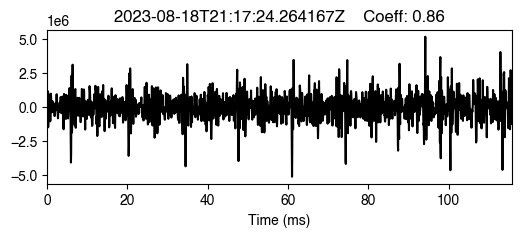

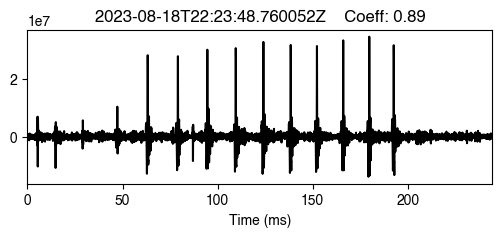

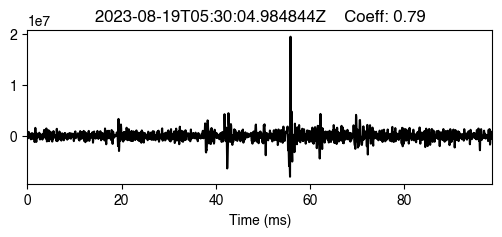

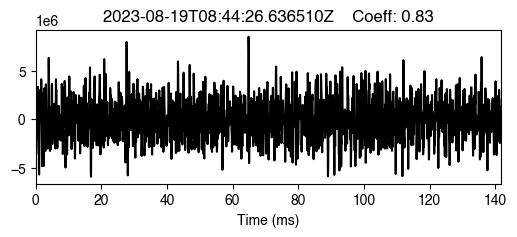

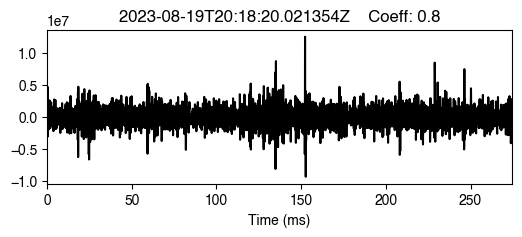

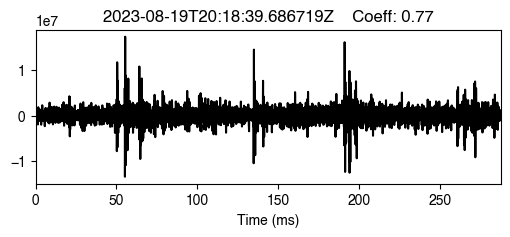

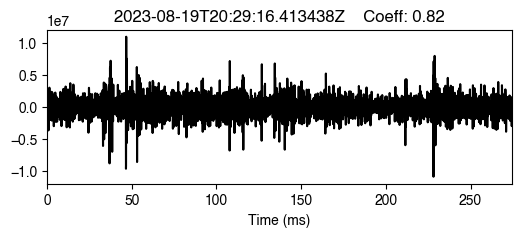

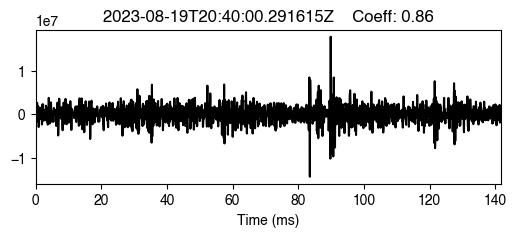

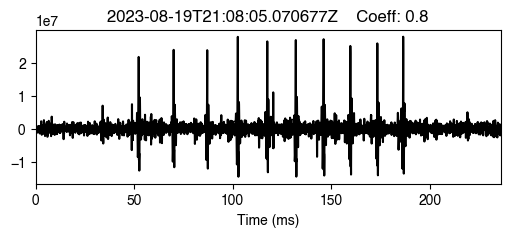

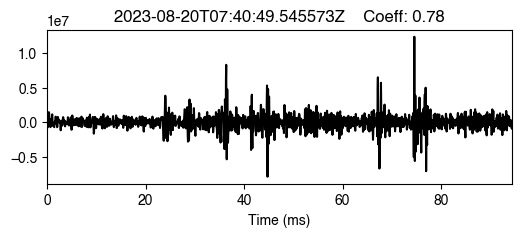

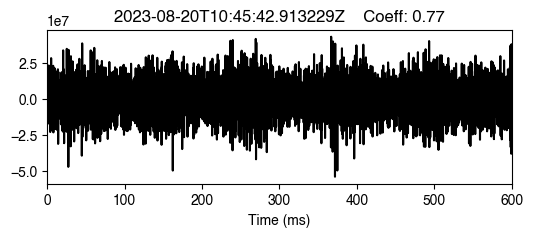

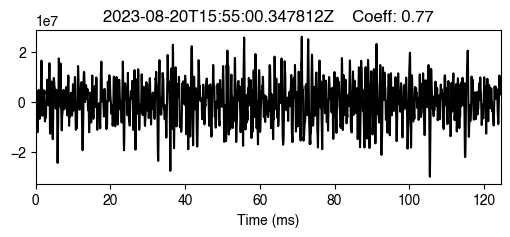

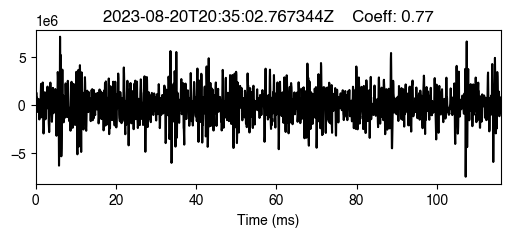

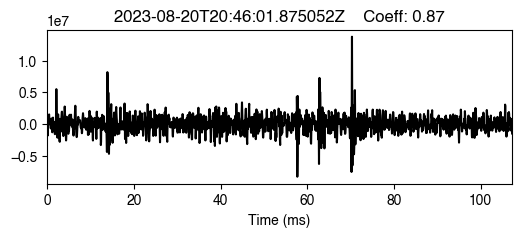

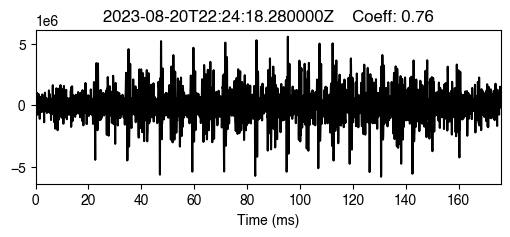

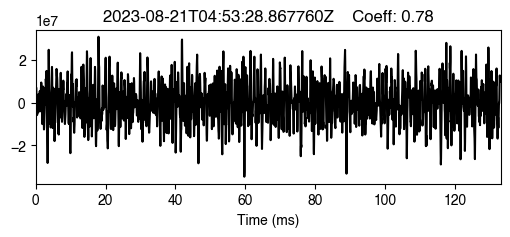

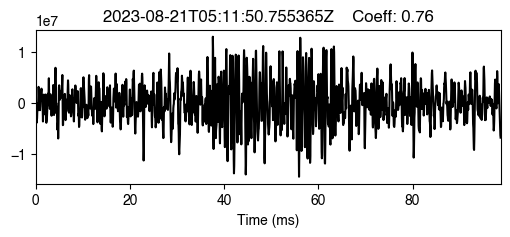

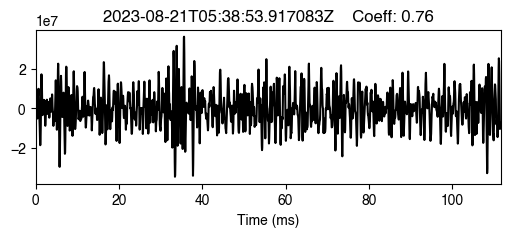

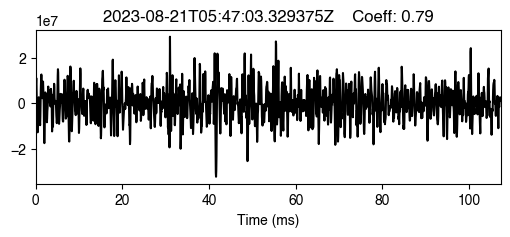

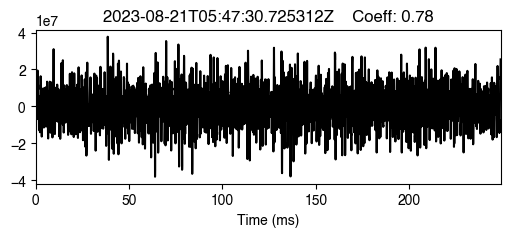

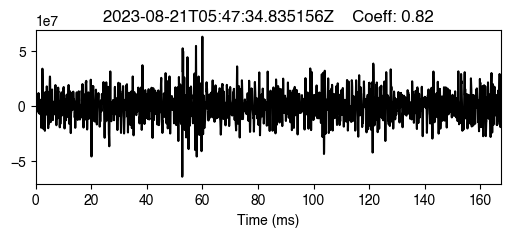

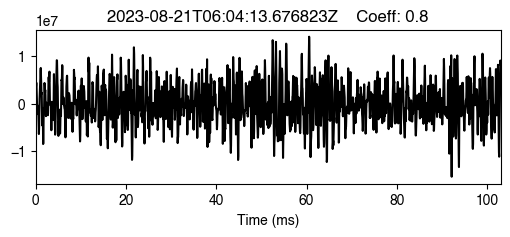

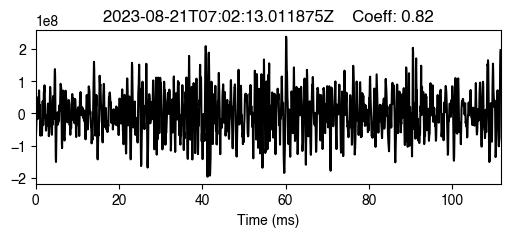

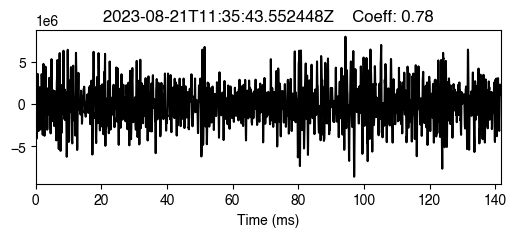

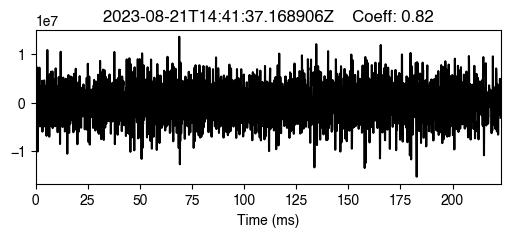

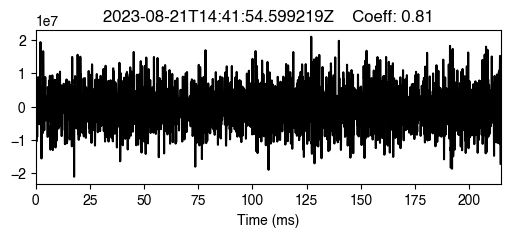

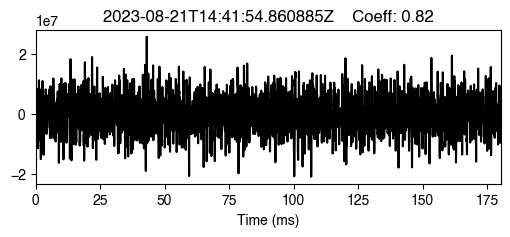

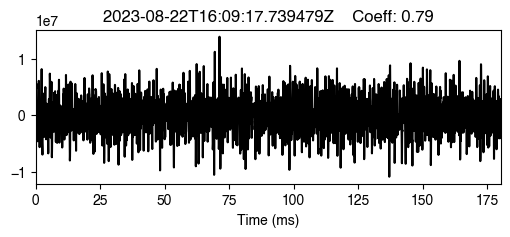

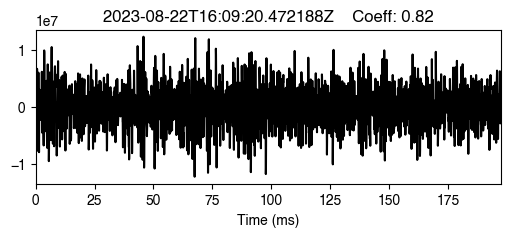

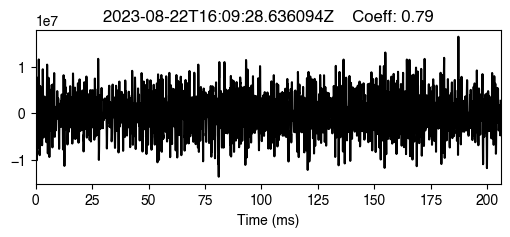

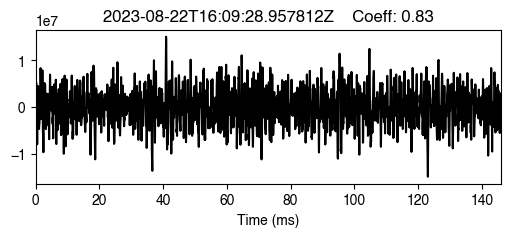

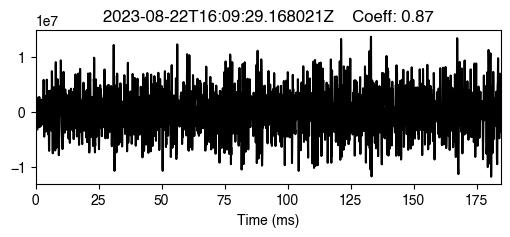

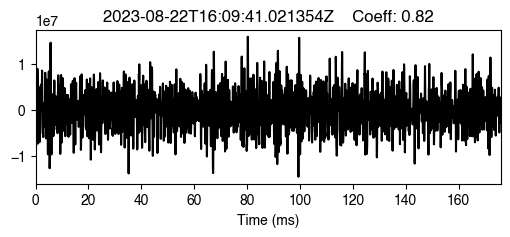

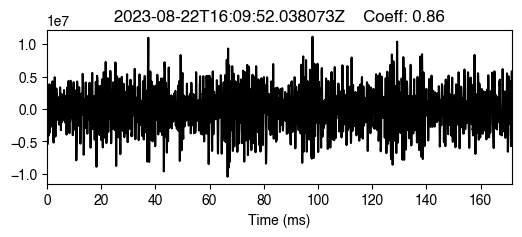

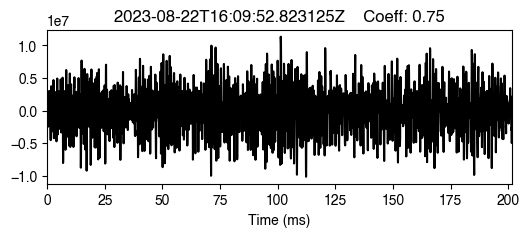

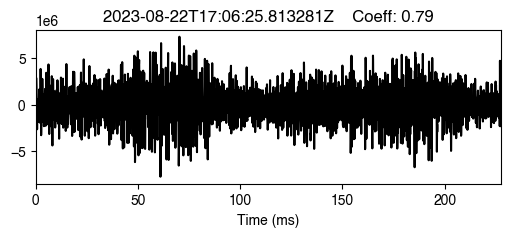

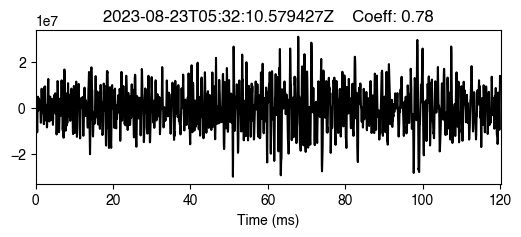

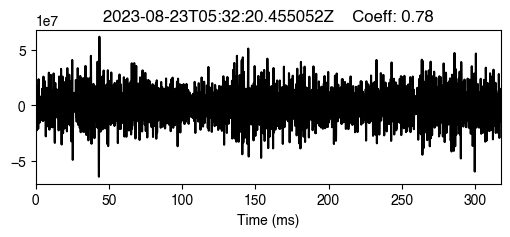

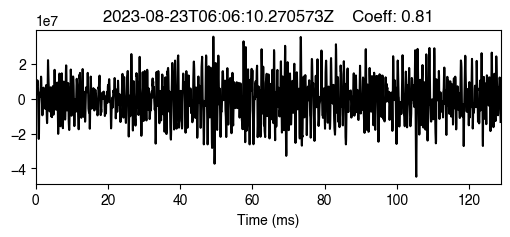

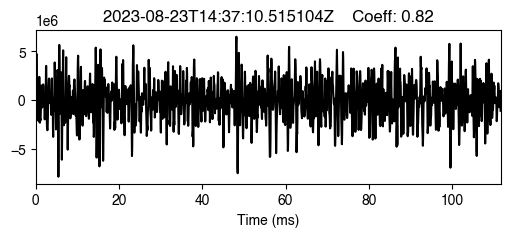

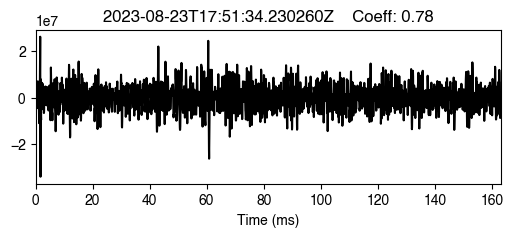

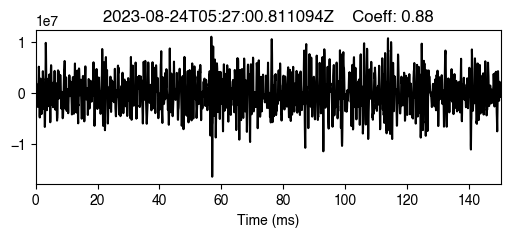

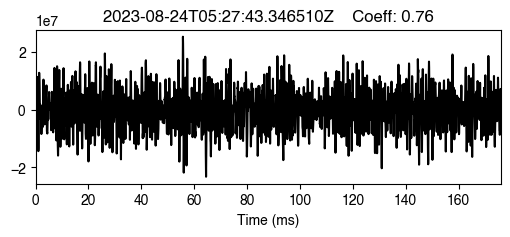

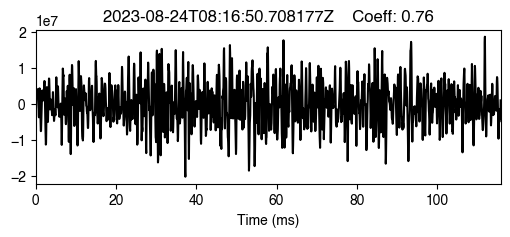

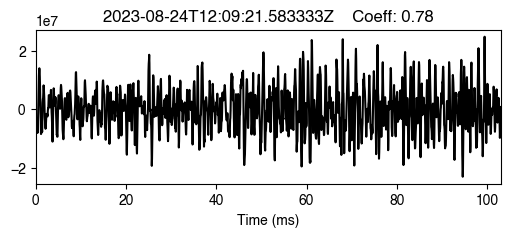

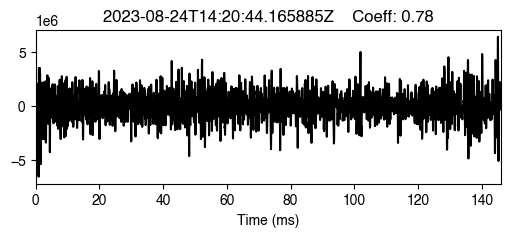

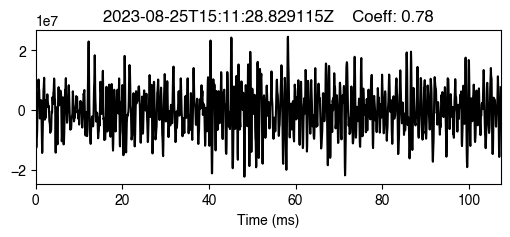

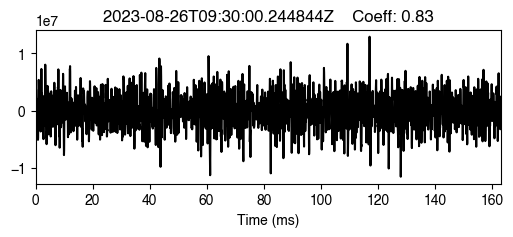

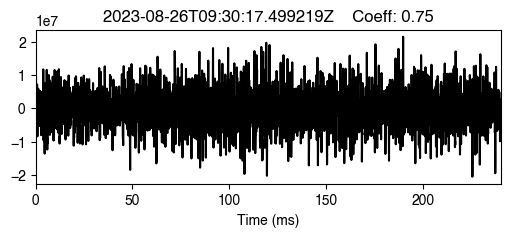

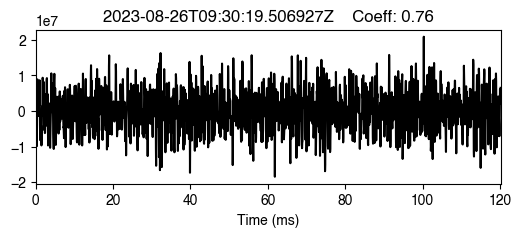

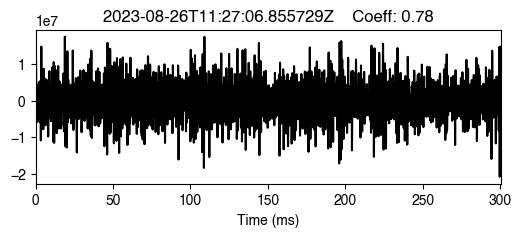

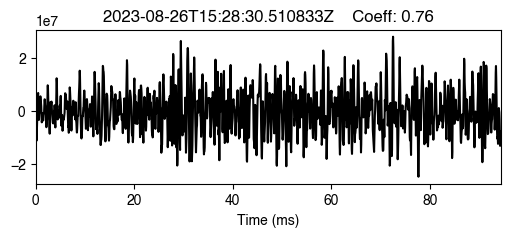

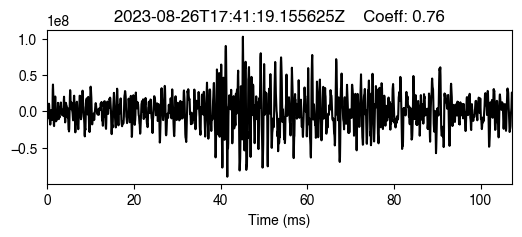

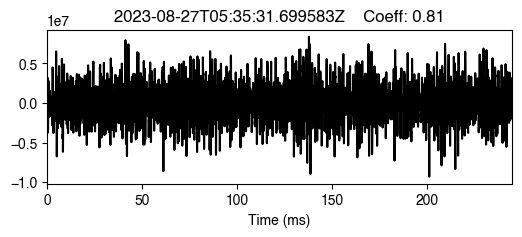

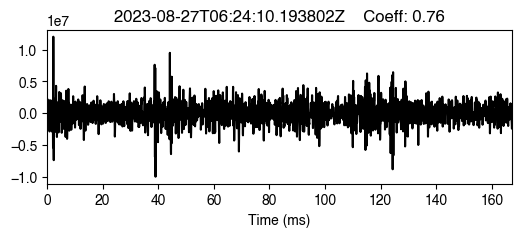

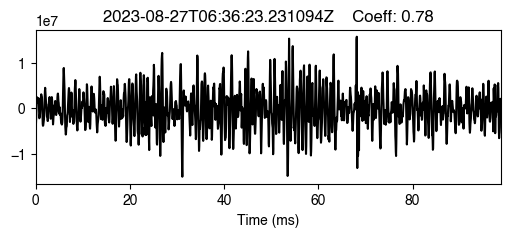

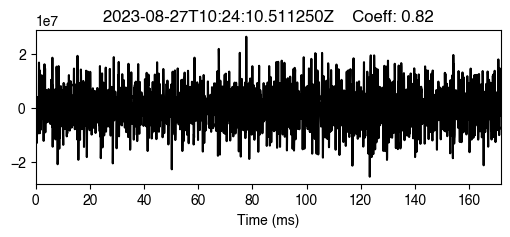

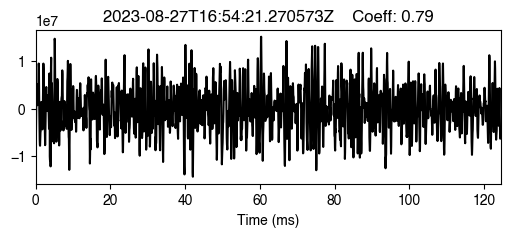

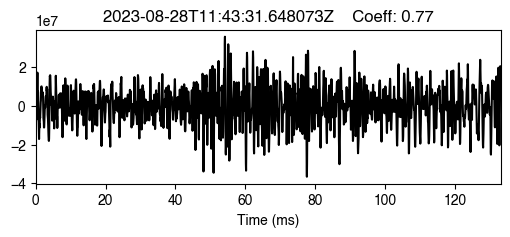

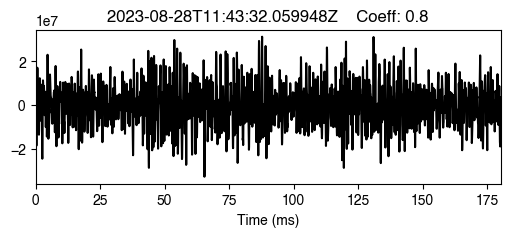

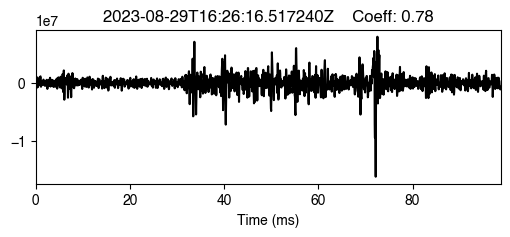

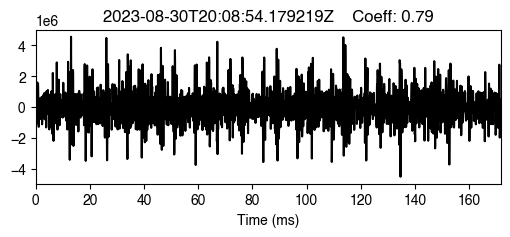

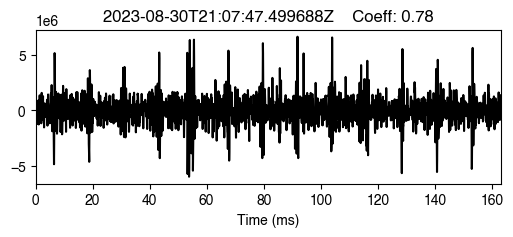

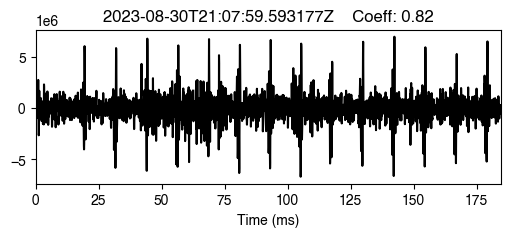

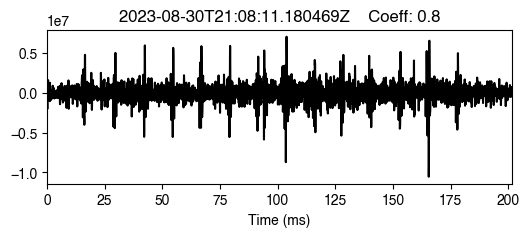

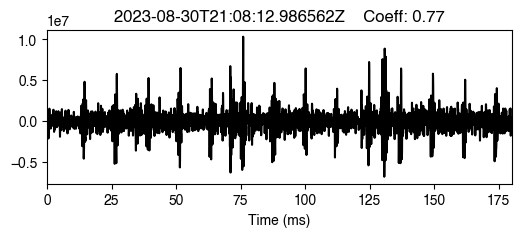

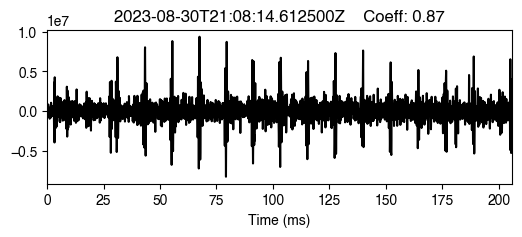

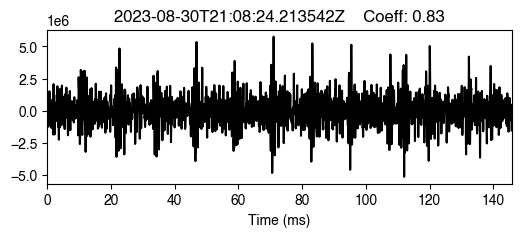

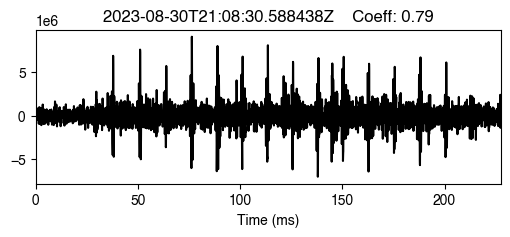

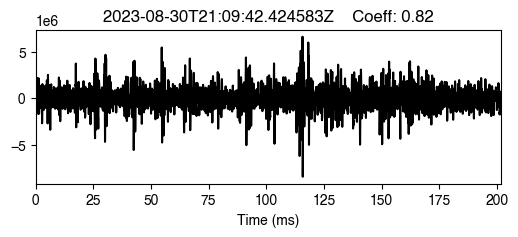

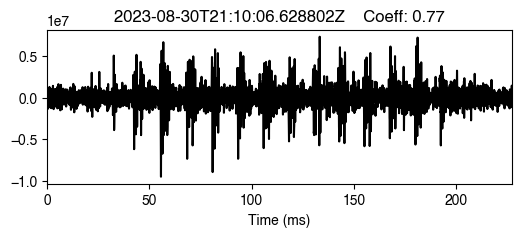

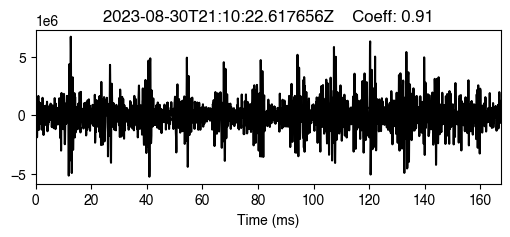

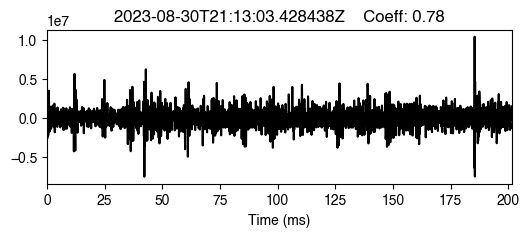

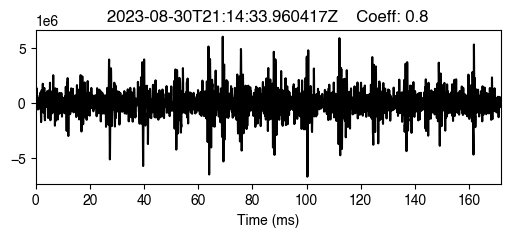

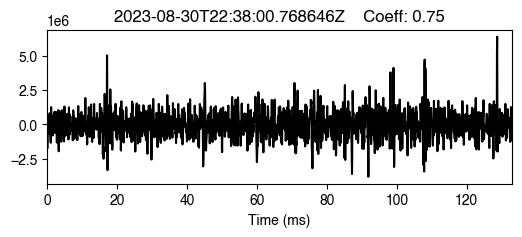

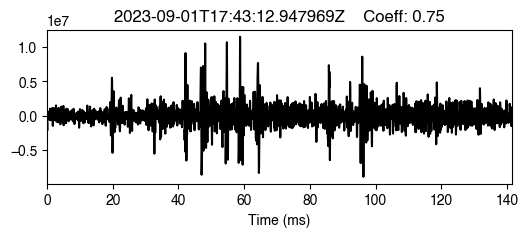

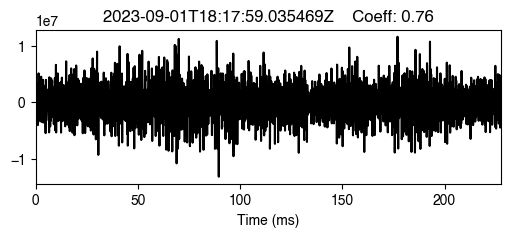

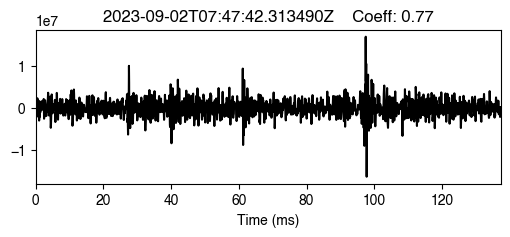

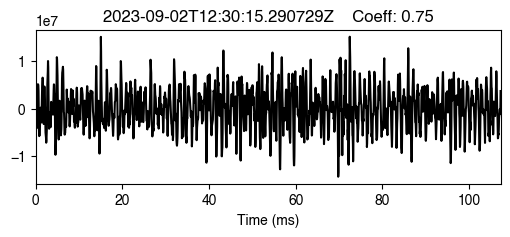

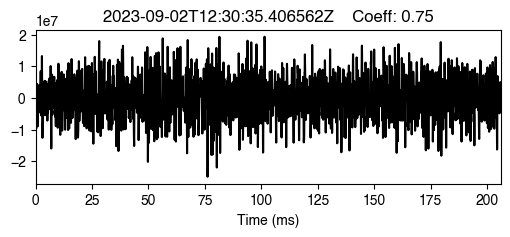

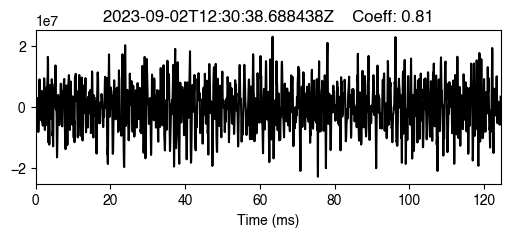

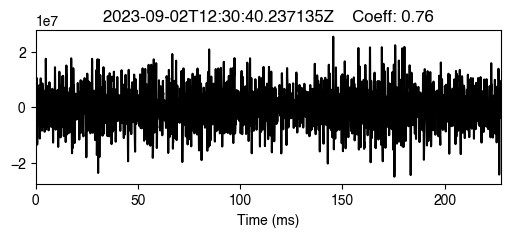

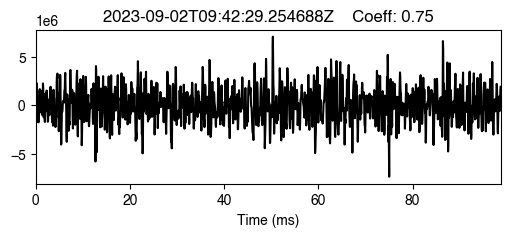

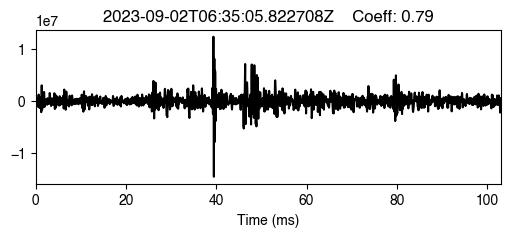

In [4]:
allSNR = pd.DataFrame()
for d in range(0,16):
    current = begin+timedelta(days=d)
    yy = str(current.year)[2:4]
    mm = str(current.month).zfill(2)
    dd = str(current.day).zfill(2)
    daydf = pd.DataFrame()
    
    for dirpath in glob.glob(f'{path}/{yy}{mm}{dd}*'):
        hhdf = pd.DataFrame()
        
        for file in glob.glob(f'{dirpath}/*.mat'):
            mat = spio.loadmat(file, struct_as_record=False, squeeze_me=True)
            df = to_pandas(mat)
            _df = df[df['peaks']>=5]
            hhdf = pd.concat([hhdf, _df]) 
            coefflist = [] 
        if len(hhdf)>0:
            print(dirpath, len(hhdf))
            globwav = glob.glob(f'{wavdir}/*{dirpath.rsplit("/")[-1]}*')[0]
            # print(globwav)
            tr = readwav(globwav, S)
            # print()

            for i in range(len(hhdf)):
                begintmp = re.split('[(|)|,]',hhdf['time_min_date'].values[i]); endtmp = re.split('[(|)|,]',hhdf['time_max_date'].values[i])
                tr_begin = UTCDateTime(int(begintmp[1]),int(begintmp[2]),int(begintmp[3]),int(begintmp[4]),int(begintmp[5]),int(begintmp[6]),int(begintmp[7]))
                tr_end = UTCDateTime(int(endtmp[1]),int(endtmp[2]),int(endtmp[3]),int(endtmp[4]),int(endtmp[5]),int(endtmp[6]),int(endtmp[7]))
                tr_slice = tr.copy()
                tr_slice = tr_slice.slice(tr_begin, tr_end); del begintmp, endtmp
                if tr_slice.stats.npts > tr_ex_slice.stats.npts:
                    diff_pt = tr_slice.stats.npts - tr_ex_slice.stats.npts
                    tr_ex_slice_zero = tr_ex_slice.copy()
                    tr_ex_slice_zero.data = np.hstack((tr_ex_slice.data, np.zeros(diff_pt)))
                    # print(len(tr_ex_slice_zero.data), len(tr_slice.data))
                    coeff = ccf_coeff(tr_ex_slice_zero, tr_slice)
                elif tr_ex_slice.stats.npts > tr_slice.stats.npts:
                    diff_pt = tr_ex_slice.stats.npts - tr_slice.stats.npts
                    tr_slice_zero = tr_slice.copy()
                    tr_slice_zero.data = np.hstack((tr_slice_zero.data, np.zeros(diff_pt)))
                    # print(len(tr_slice_zero.data), len(tr_ex_slice.data))
                    coeff = ccf_coeff(tr_ex_slice, tr_slice_zero)
                coefflist.append(coeff[0][1])
                if coeff[0][1] >=0.75:
                    # print()
                    plt.figure(figsize=(6,2))
                    plt.rc('font', family='Helvetica')
                    plt.plot(tr_slice.times()*1000, tr_slice.data, 'k')
                    plt.xlim(tr_slice.times()[0]*1000, tr_slice.times()[-1]*1000)
                    plt.title(f'{tr_slice.stats.starttime}    Coeff: {round(coeff[0][1], 2)}')
                    plt.xlabel('Time (ms)')
                    
                    hour = str(tr_slice.stats.starttime.hour).zfill(2)
                    minute = str(tr_slice.stats.starttime.minute).zfill(2)
                    second = str(tr_slice.stats.starttime.second).zfill(2)
                    plt.savefig(f'../Results/Detection_fishcall/fig/{yy}{mm}{dd}_{hour}{minute}{second}.png', bbox_inches='tight')
                    plt.close()
            hhdf['coeff'] = coefflist
        daydf = pd.concat([daydf, hhdf], ignore_index=True)
    daydf.to_csv(f'../Results/Detection_fishcall/csv/result_{yy}{mm}{dd}.csv', index=False)
    
                            ## cross correlation 

                

In [14]:
path = '/Volumes/home/Research/Detect_fish/Taoyuan_fig'
for day in range(8,9):
    dayy = str(day).zfill(2)
    datepath = f'{path}/230608-230623/2306{dayy}'
    cmd = 'mkdir %(datepath)s' %locals()
    # os.system(cmd)
    
    cmd = 'mv /Volumes/home/Research/Detect_fish/Taoyuan_fig/230608-230623/2306%(dayy)s?? %(datepath)s' %locals()
    # os.system(cmd)    
    